In [ ]:
 !pip install pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

file_path = "part-00000-0afb19c5-27a3-4cce-8f99-0cb43406a020-c000.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.show(5)


+-----------+---------+------+------------------+---------+--------------------------+-------------------+----------------------+------------------------+---------------+-----------------------------+--------------------+-----------------+
|Customer_ID|      Age|Gender|          Location|   Income|Ride_Frequency (per month)|Preferred_Ride_Type|Avg_Ride_Distance (km)|Avg_Ride_Duration (mins)|Total_Spend ($)|Booking_Hours (peak/off-peak)|Loyalty_Member (Y/N)|   Feedback_Score|
+-----------+---------+------+------------------+---------+--------------------------+-------------------+----------------------+------------------------+---------------+-----------------------------+--------------------+-----------------+
|     266649| 78.96342| Other|114.71692583669358| 143706.0|                      19.0|            Scooter|              45.17197|                   199.0|       329.1317|                         peak|                   1|2.981072587111291|
|     499232| 49.18659|     0|          

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Encoding categorical features
indexer = StringIndexer(inputCols=["Gender", "Location", "Preferred_Ride_Type", "Booking_Hours (peak/off-peak)", "Loyalty_Member (Y/N)"],
                        outputCols=["Gender_Idx", "Location_Idx", "Ride_Type_Idx", "Booking_Hours_Idx", "Loyalty_Idx"])
df = indexer.fit(df).transform(df)

# Vectorizing features
feature_cols = ["Age", "Income", "Ride_Frequency (per month)", "Avg_Ride_Distance (km)", "Avg_Ride_Duration (mins)",
                "Total_Spend ($)", "Gender_Idx", "Location_Idx", "Ride_Type_Idx", "Booking_Hours_Idx", "Loyalty_Idx"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)


In [ ]:
# Standardizing features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Applying K-Means
kmeans = KMeans(featuresCol="scaled_features", k=4, seed=1)
model = kmeans.fit(df)
df = model.transform(df)

# Display cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)


Cluster Centers: 
[3.01566909 2.68258744 2.16335409 2.21450956 2.71545421 2.20296136
 1.0412662  1.85945461 1.56157977 0.06187195 1.49092073]
[2.82224479 3.04748999 2.16101644 2.21935491 2.16866399 1.06371882
 1.58315336 0.75339609 0.75706162 0.54383245 0.48752465]
[3.41452594 2.6927768  1.56404189 1.41903017 2.41029097 1.80881542
 1.32022328 1.22671786 1.58964881 1.81179761 1.34538405]
[2.53876502 3.50297199 1.47759855 2.28545524 2.16745312 2.31792052
 0.46604737 1.36100853 1.26815691 1.31949622 0.23504912]


In [ ]:
df = df.withColumnRenamed("prediction", "label")  # Label is the segment from KMeans

# Split data into training and test sets
train_data, test_data = df.randomSplit([0.7, 0.3], seed=123)


In [ ]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="label")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Evaluate Logistic Regression
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")


Logistic Regression Accuracy: 0.9752066115702479


In [ ]:
dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="label")
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# Evaluate Decision Tree
dt_accuracy = evaluator.evaluate(dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy}")


Decision Tree Accuracy: 0.6528925619834711


In [ ]:
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="label")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Evaluate Random Forest
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")


Random Forest Accuracy: 0.7851239669421488


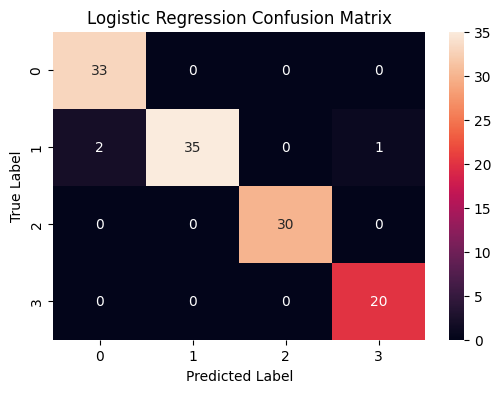

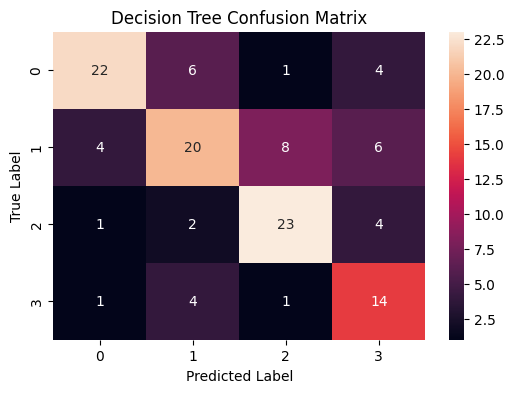

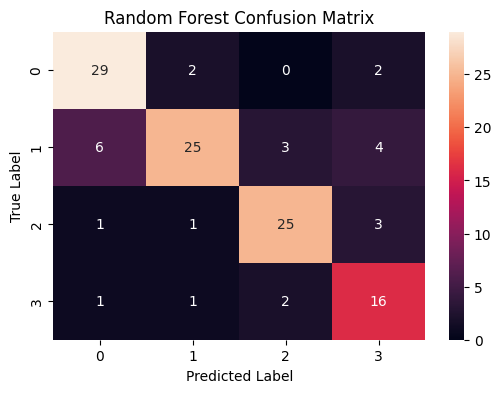

In [ ]:
# Convert Spark predictions to Pandas DataFrame
lr_pred = lr_predictions.select("prediction", "label").toPandas()
dt_pred = dt_predictions.select("prediction", "label").toPandas()
rf_pred = rf_predictions.select("prediction", "label").toPandas()

# Plot Confusion Matrix
for model_name, preds in zip(["Logistic Regression", "Decision Tree", "Random Forest"], [lr_pred, dt_pred, rf_pred]):
    cm = confusion_matrix(preds["label"], preds["prediction"])
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


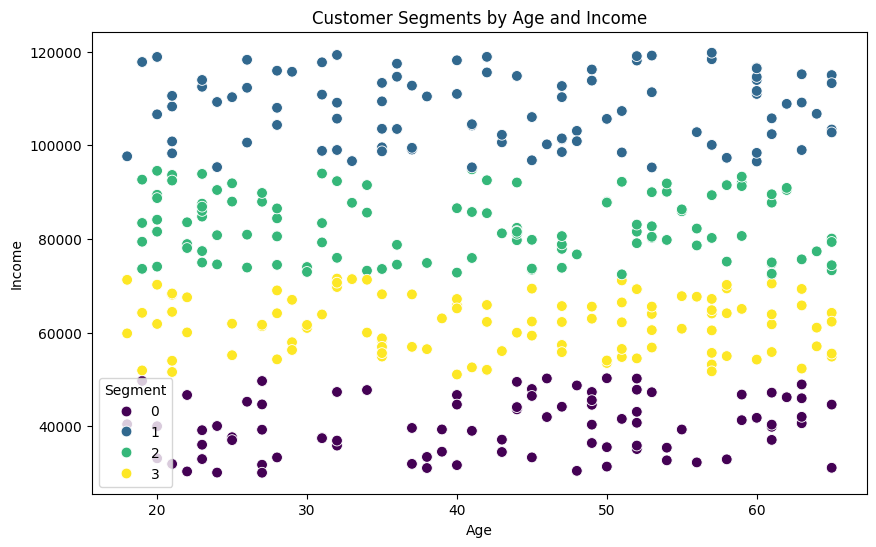

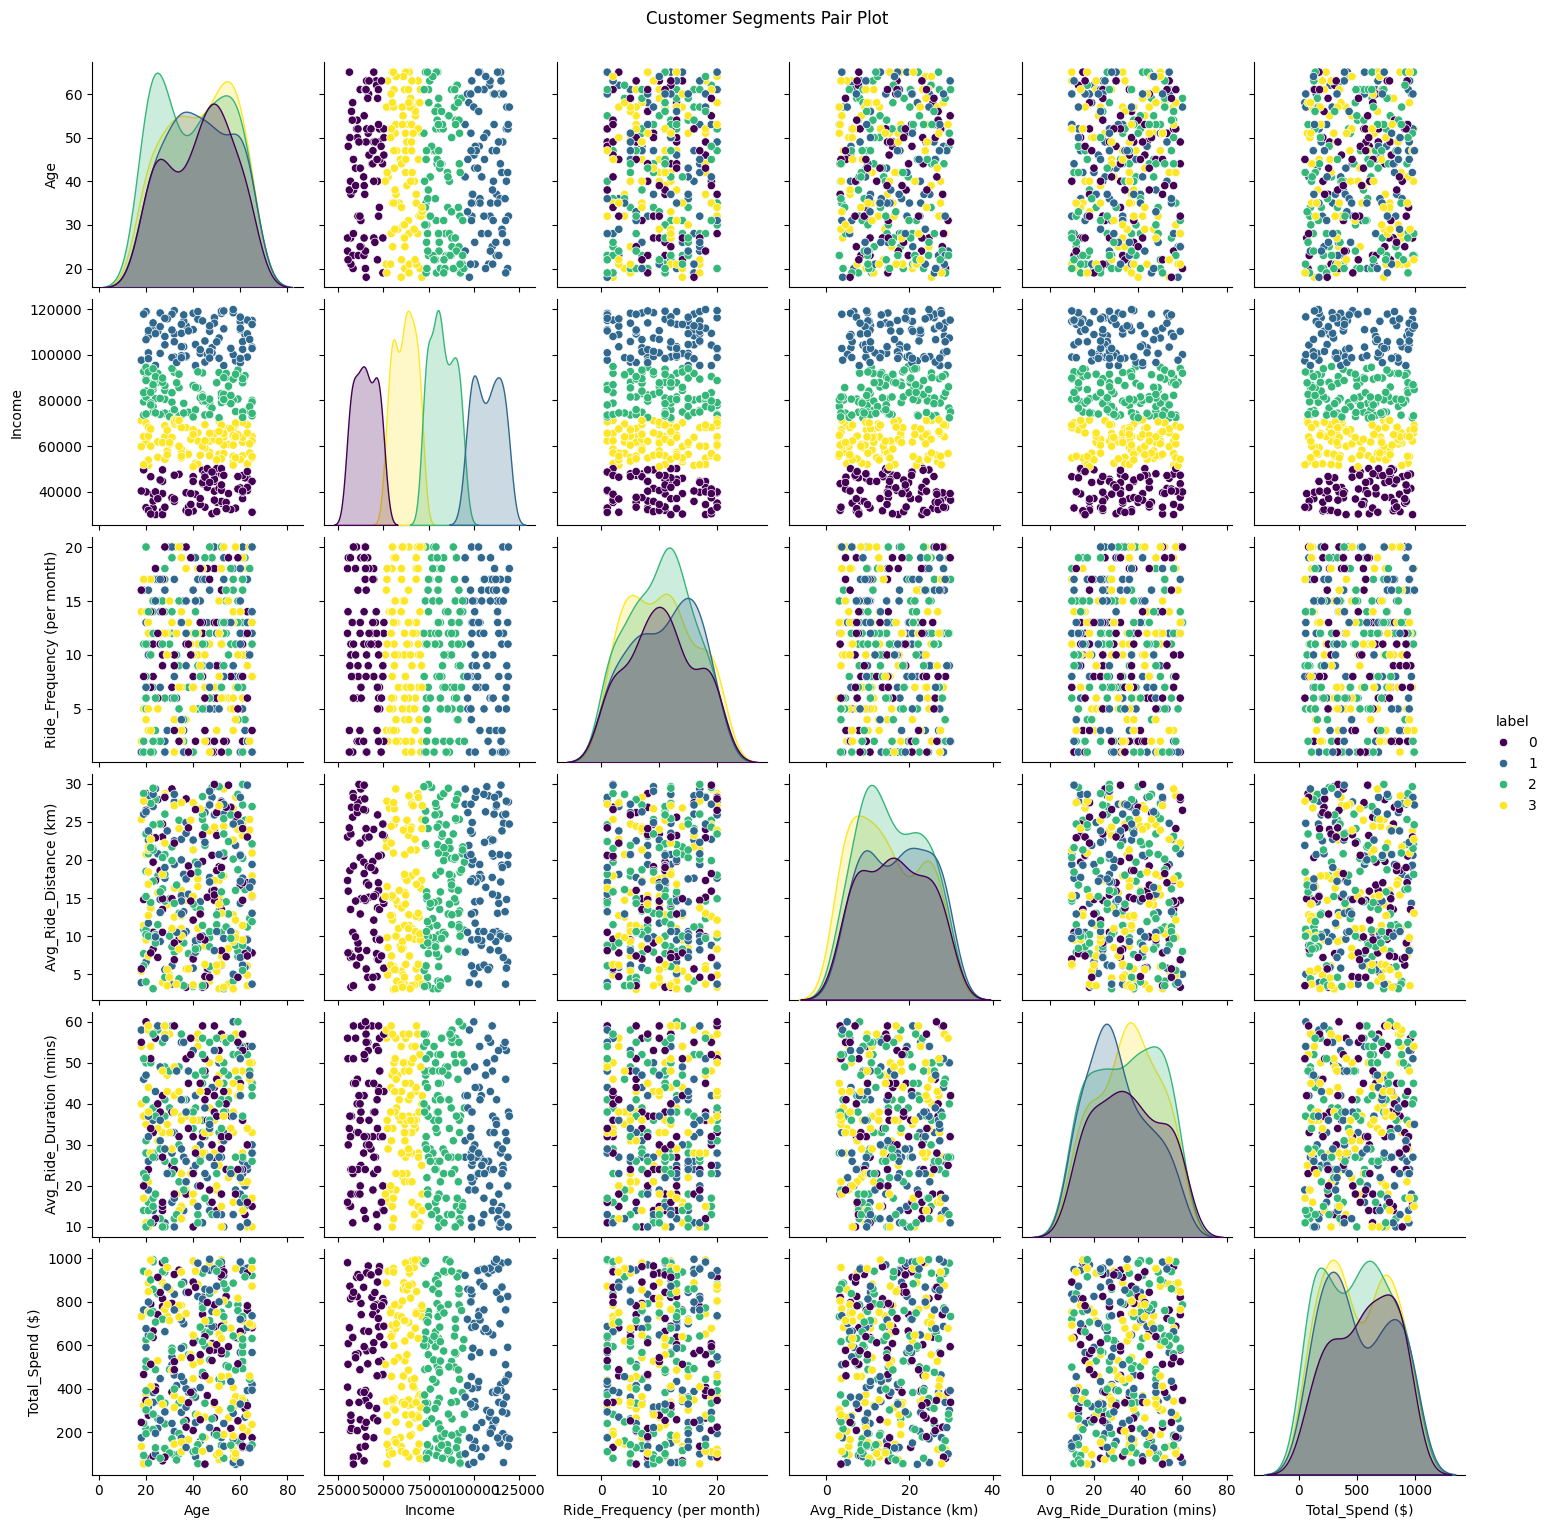

<ipython-input-14-e6c371efbae5>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="Income", data=df_pandas, palette="viridis")


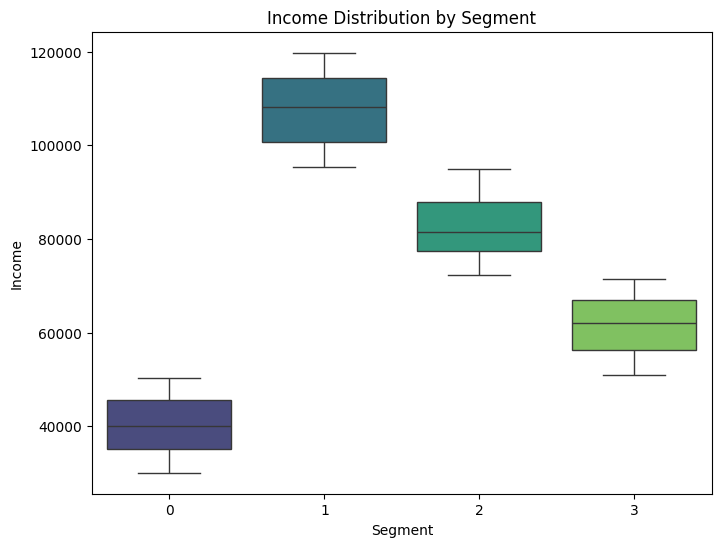

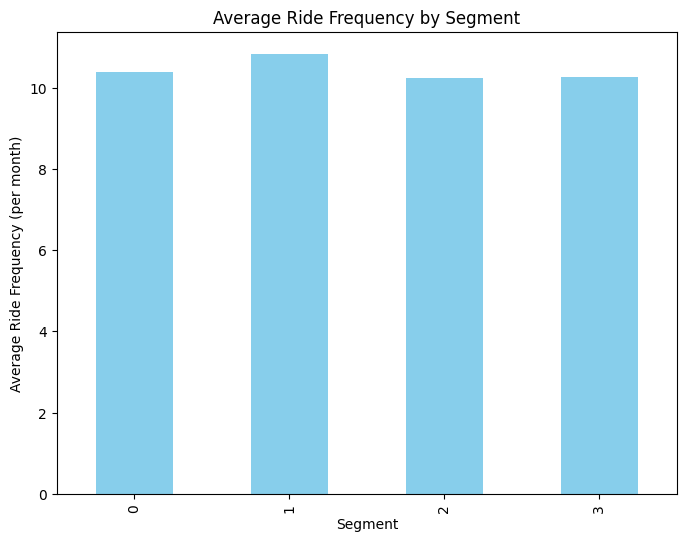

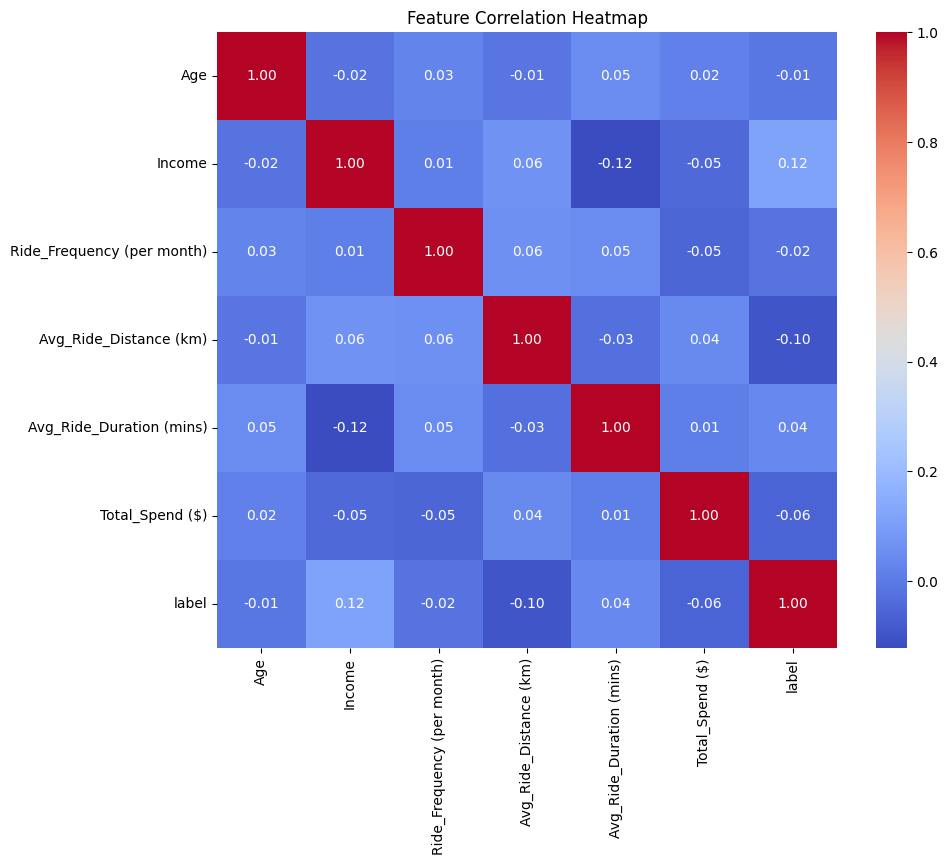

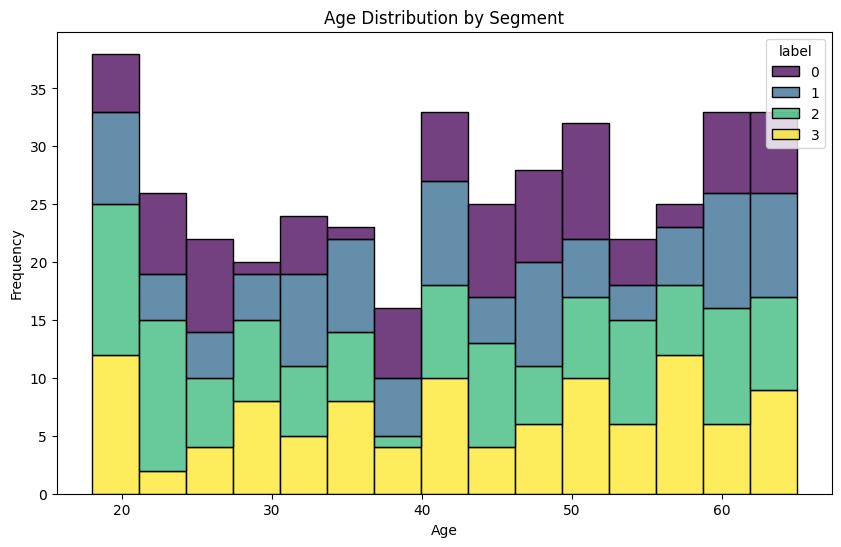

<ipython-input-14-e6c371efbae5>:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="label", y="Total_Spend ($)", data=df_pandas, palette="viridis")


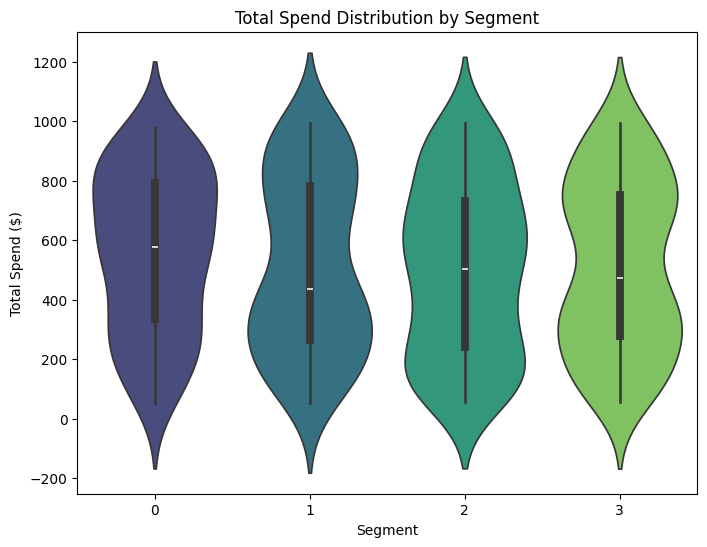

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# Initialize Spark session
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

# Load the dataset
file_path = "uber_customer_segmentation_dataset.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Assemble features into a single vector column for clustering
assembler = VectorAssembler(inputCols=["Age", "Income", "Ride_Frequency (per month)",
                                       "Avg_Ride_Distance (km)", "Avg_Ride_Duration (mins)",
                                       "Total_Spend ($)"], outputCol="features")
df_features = assembler.transform(df)

# Apply KMeans Clustering
kmeans = KMeans(k=4, seed=1, featuresCol="features", predictionCol="label")
model = kmeans.fit(df_features)
df_clustered = model.transform(df_features)

# Convert Spark DataFrame with segments to Pandas DataFrame for visualization
df_pandas = df_clustered.select("Age", "Income", "Ride_Frequency (per month)", "Avg_Ride_Distance (km)",
                                "Avg_Ride_Duration (mins)", "Total_Spend ($)", "label").toPandas()

# Scatter Plot: Age vs. Income colored by Segment
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Age", y="Income", hue="label", data=df_pandas, palette="viridis", s=60)
plt.title("Customer Segments by Age and Income")
plt.xlabel("Age")
plt.ylabel("Income")
plt.legend(title="Segment")
plt.show()

# Pair Plot: Multivariate relationships colored by Segment
sns.pairplot(df_pandas, hue="label", palette="viridis", diag_kind="kde")
plt.suptitle("Customer Segments Pair Plot", y=1.02)
plt.show()

# Box Plot: Income by Segment
plt.figure(figsize=(8, 6))
sns.boxplot(x="label", y="Income", data=df_pandas, palette="viridis")
plt.title("Income Distribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Income")
plt.show()

# Bar Plot: Average Ride Frequency by Segment
avg_ride_frequency = df_pandas.groupby("label")["Ride_Frequency (per month)"].mean()
avg_ride_frequency.plot(kind="bar", color="skyblue", figsize=(8, 6))
plt.title("Average Ride Frequency by Segment")
plt.xlabel("Segment")
plt.ylabel("Average Ride Frequency (per month)")
plt.show()

# Heatmap: Correlation matrix of features
plt.figure(figsize=(10, 8))
sns.heatmap(df_pandas.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Histogram: Age distribution by Segment
plt.figure(figsize=(10, 6))
sns.histplot(df_pandas, x="Age", hue="label", multiple="stack", palette="viridis", bins=15)
plt.title("Age Distribution by Segment")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Violin Plot: Total Spend by Segment
plt.figure(figsize=(8, 6))
sns.violinplot(x="label", y="Total_Spend ($)", data=df_pandas, palette="viridis")
plt.title("Total Spend Distribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Total Spend ($)")
plt.show()


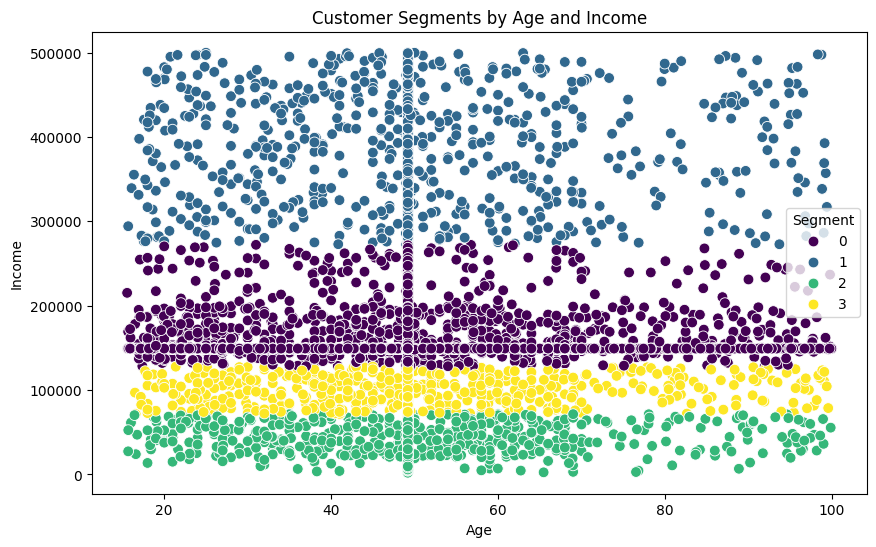

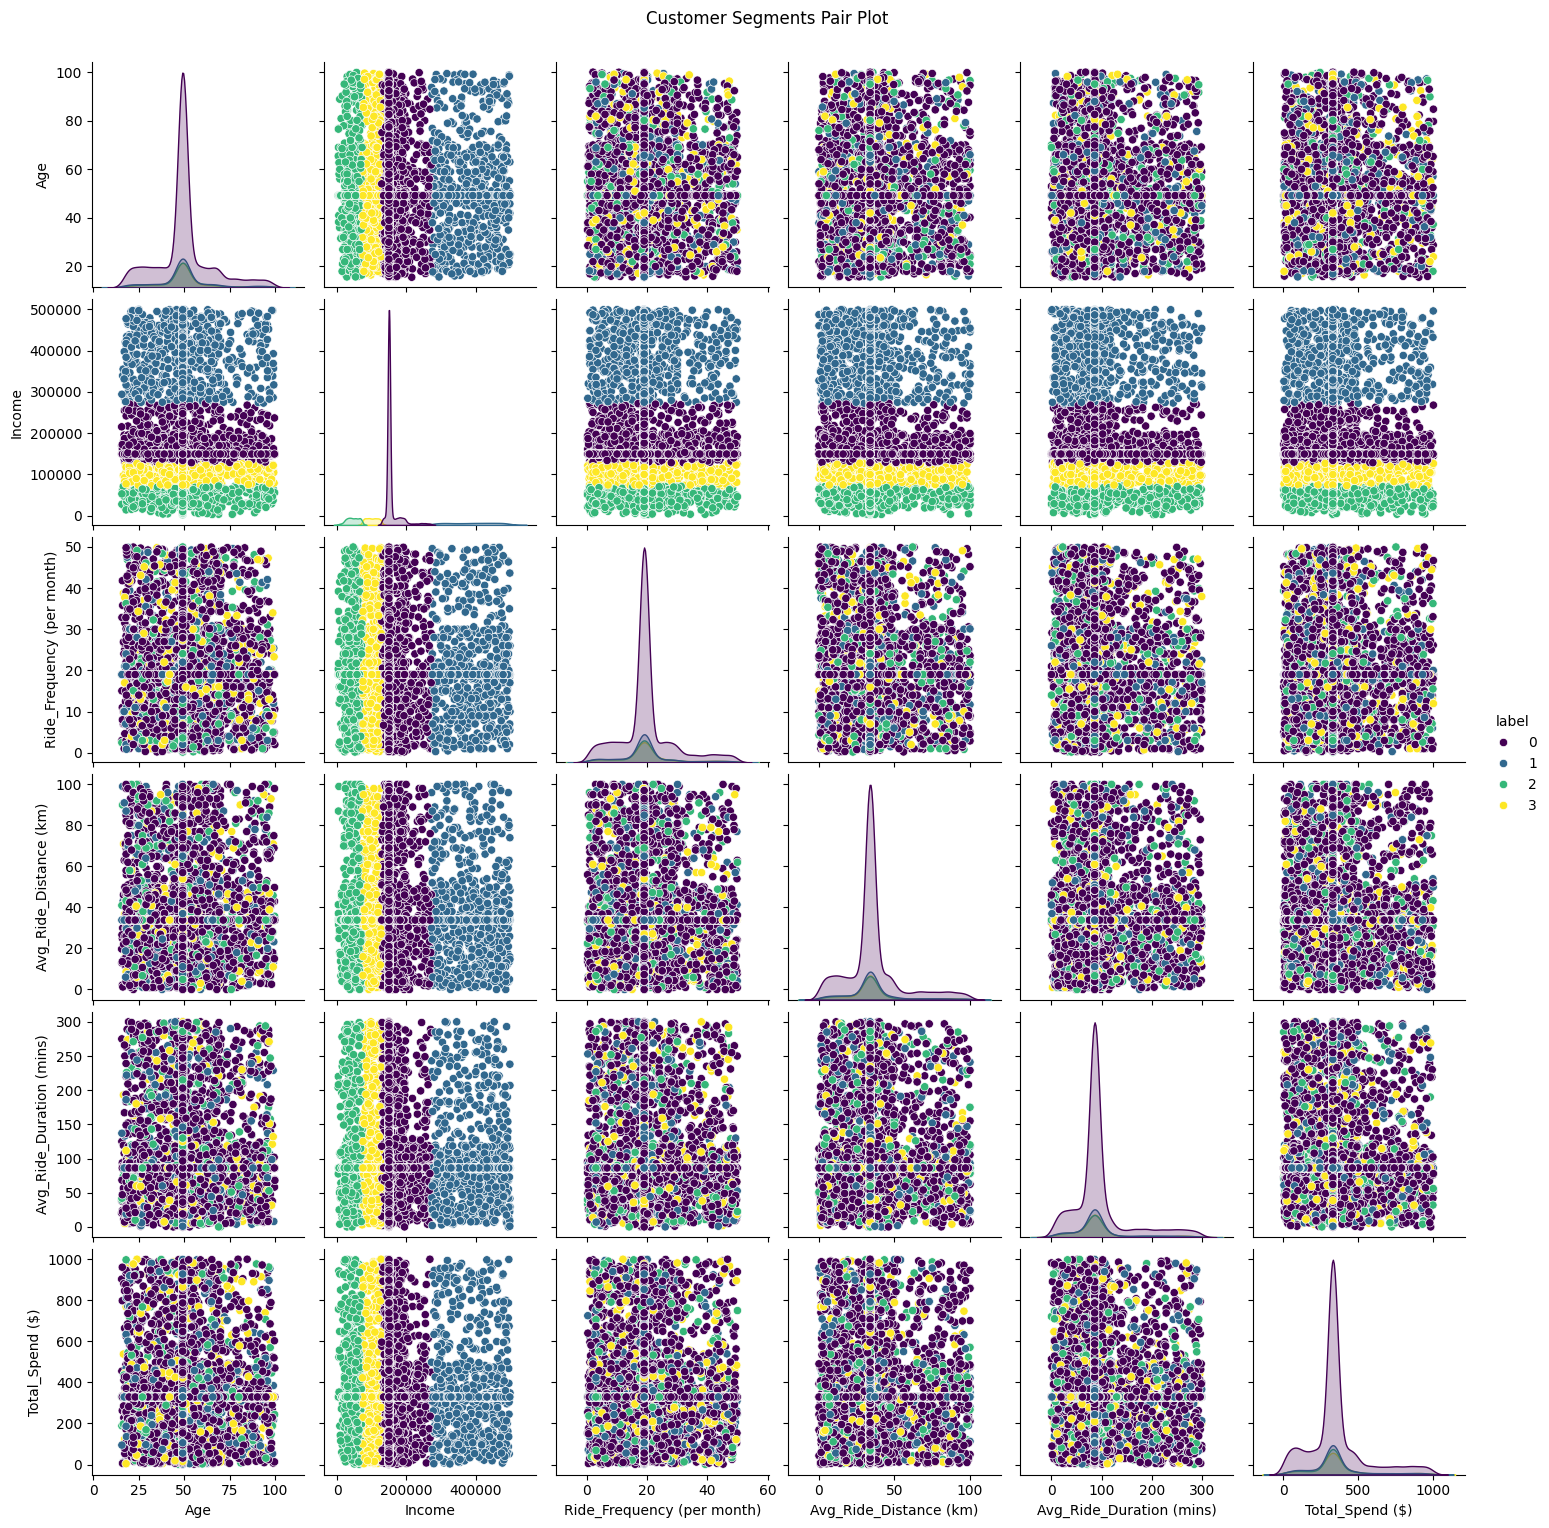

<ipython-input-3-1fd43e7cce29>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="Income", data=df_pandas, palette="viridis")


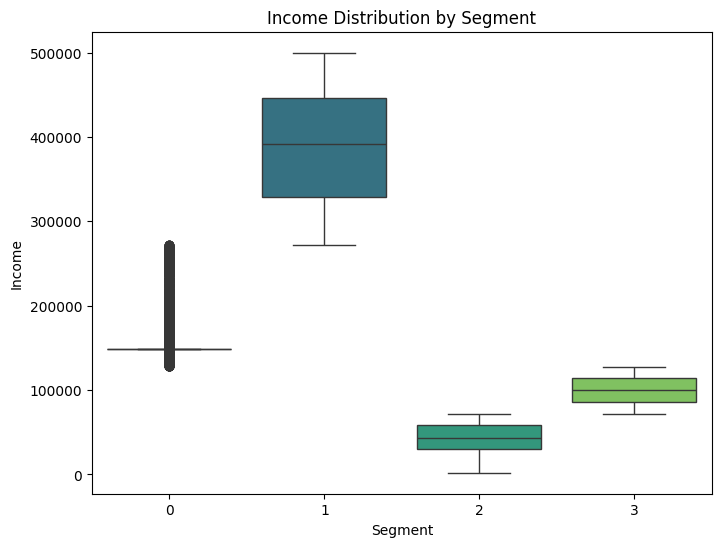

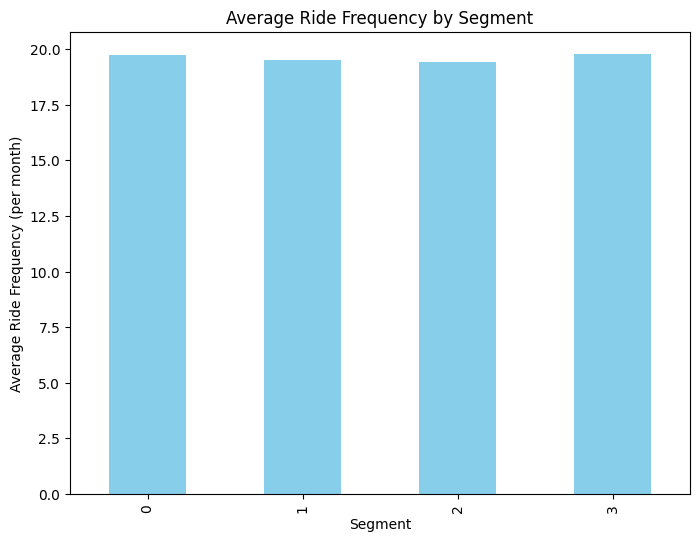

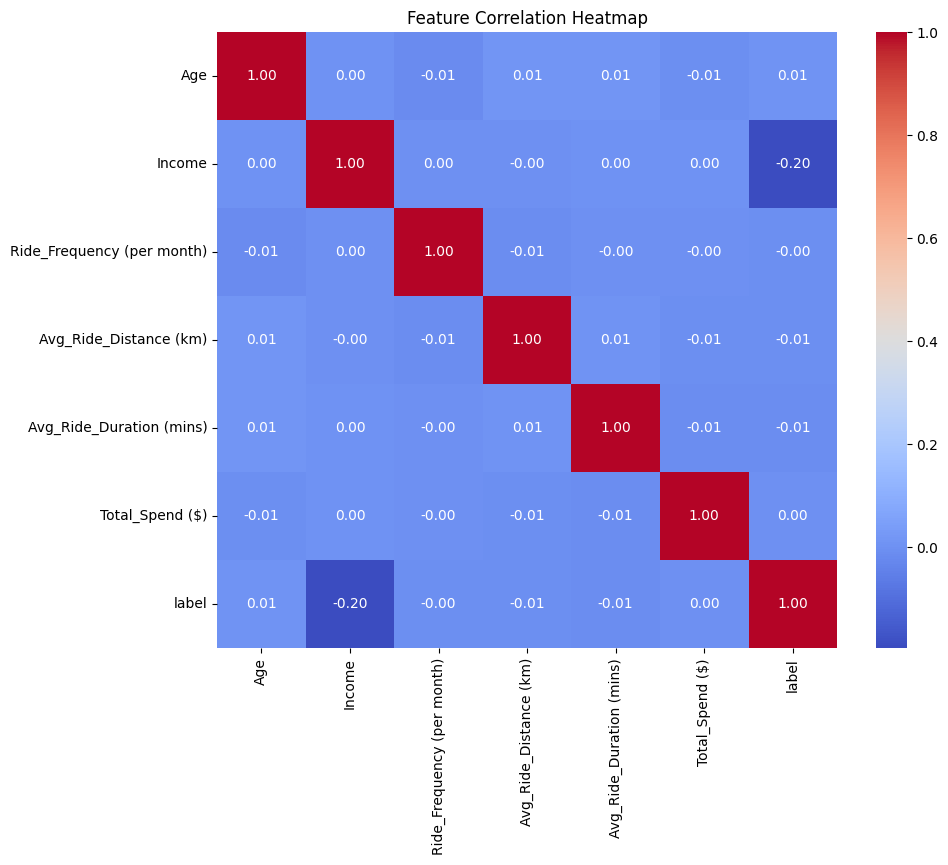

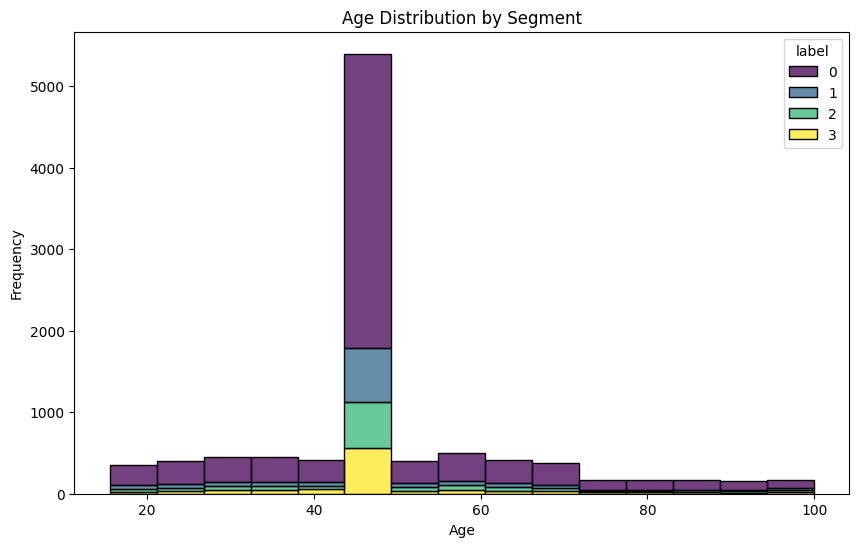

<ipython-input-3-1fd43e7cce29>:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="label", y="Total_Spend ($)", data=df_pandas, palette="viridis")


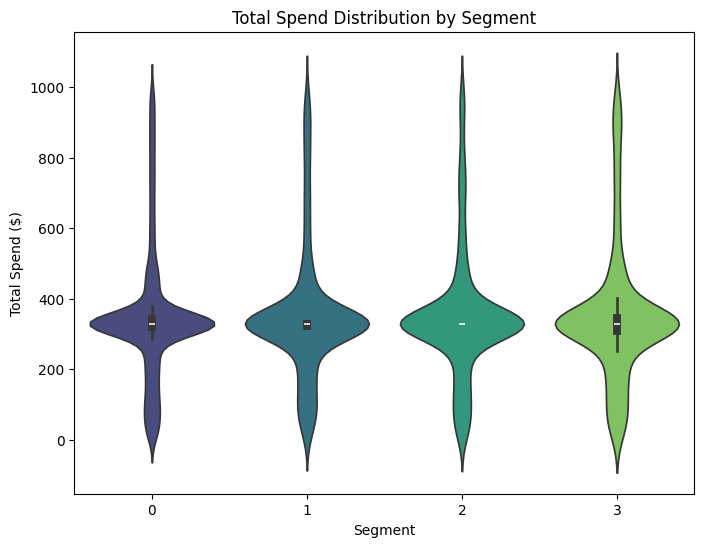

In [ ]:
from pyspark.sql.functions import col, count, lit, when

# 1. Cleaning the dataset

# Replace any string values like 'unknown', empty strings, or invalid values with None
df_cleaned = df.replace(['unknown', '', ' '], None)

# Drop rows with too many missing values (optional threshold, here dropping if > 2 missing)
df_cleaned = df_cleaned.dropna(thresh=4)

# Filling missing numerical values
numeric_cols = ["Age", "Income", "Ride_Frequency (per month)", "Avg_Ride_Distance (km)", "Avg_Ride_Duration (mins)", "Total_Spend ($)"]

# Cast these columns to float (or integer) where applicable
for col_name in numeric_cols:
    df_cleaned = df_cleaned.withColumn(col_name, col(col_name).cast("float"))

# Calculate the median for each numeric column
for col_name in numeric_cols:
    median_value = df_cleaned.agg({"{}".format(col_name): "median"}).collect()[0][0]
    if median_value is not None:
        df_cleaned = df_cleaned.fillna({col_name: median_value})

# Filling missing categorical values with the most frequent value (mode)
categorical_cols = ["Gender", "Preferred_Ride_Type", "Booking_Hours (peak/off-peak)", "Loyalty_Member (Y/N)"]

# For categorical columns, calculate the mode and use that to fill missing values
for col_name in categorical_cols:
    mode_value = df_cleaned.groupBy(col_name).count().orderBy("count", ascending=False).first()[0]
    if mode_value is not None:
        df_cleaned = df_cleaned.withColumn(col_name, when(col(col_name).isNull(), lit(mode_value)).otherwise(col(col_name)))

# Now df_cleaned should have the missing values handled correctly

# 2. Save the cleaned dataset to CSV
cleaned_file_path = "cleaned_uber_customer_segmentation_dataset.csv"
df_cleaned.write.csv(cleaned_file_path, header=True, mode="overwrite")

# 3. Assemble features into a single vector column for clustering
assembler = VectorAssembler(inputCols=["Age", "Income", "Ride_Frequency (per month)",
                                       "Avg_Ride_Distance (km)", "Avg_Ride_Duration (mins)",
                                       "Total_Spend ($)"], outputCol="features")
df_features = assembler.transform(df_cleaned)

# 4. Apply KMeans Clustering
kmeans = KMeans(k=4, seed=1, featuresCol="features", predictionCol="label")
model = kmeans.fit(df_features)
df_clustered = model.transform(df_features)

# 5. Convert Spark DataFrame with segments to Pandas DataFrame for visualization
df_pandas = df_clustered.select("Age", "Income", "Ride_Frequency (per month)", "Avg_Ride_Distance (km)",
                                "Avg_Ride_Duration (mins)", "Total_Spend ($)", "label").toPandas()

# 6. Visualization

# Scatter Plot: Age vs. Income colored by Segment
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Age", y="Income", hue="label", data=df_pandas, palette="viridis", s=60)
plt.title("Customer Segments by Age and Income")
plt.xlabel("Age")
plt.ylabel("Income")
plt.legend(title="Segment")
plt.show()

# Pair Plot: Multivariate relationships colored by Segment
sns.pairplot(df_pandas, hue="label", palette="viridis", diag_kind="kde")
plt.suptitle("Customer Segments Pair Plot", y=1.02)
plt.show()

# Box Plot: Income by Segment
plt.figure(figsize=(8, 6))
sns.boxplot(x="label", y="Income", data=df_pandas, palette="viridis")
plt.title("Income Distribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Income")
plt.show()

# Bar Plot: Average Ride Frequency by Segment
avg_ride_frequency = df_pandas.groupby("label")["Ride_Frequency (per month)"].mean()
avg_ride_frequency.plot(kind="bar", color="skyblue", figsize=(8, 6))
plt.title("Average Ride Frequency by Segment")
plt.xlabel("Segment")
plt.ylabel("Average Ride Frequency (per month)")
plt.show()

# Heatmap: Correlation matrix of features
plt.figure(figsize=(10, 8))
sns.heatmap(df_pandas.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Histogram: Age distribution by Segment
plt.figure(figsize=(10, 6))
sns.histplot(df_pandas, x="Age", hue="label", multiple="stack", palette="viridis", bins=15)
plt.title("Age Distribution by Segment")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Violin Plot: Total Spend by Segment
plt.figure(figsize=(8, 6))
sns.violinplot(x="label", y="Total_Spend ($)", data=df_pandas, palette="viridis")
plt.title("Total Spend Distribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Total Spend ($)")
plt.show()


KMeans Silhouette Score: 0.8662
Logistic Regression Accuracy: 0.4035
Random Forest Accuracy: 0.4024


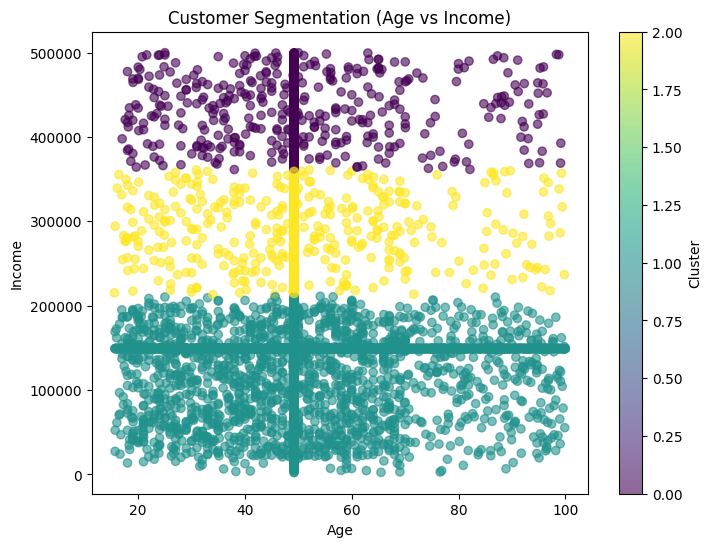

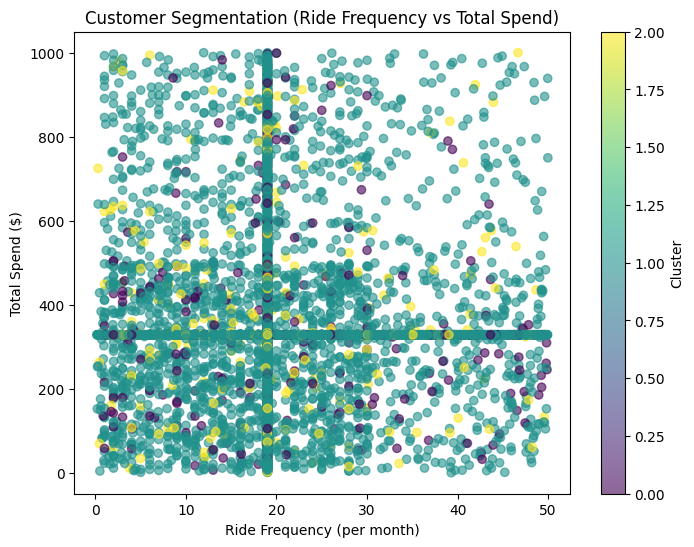

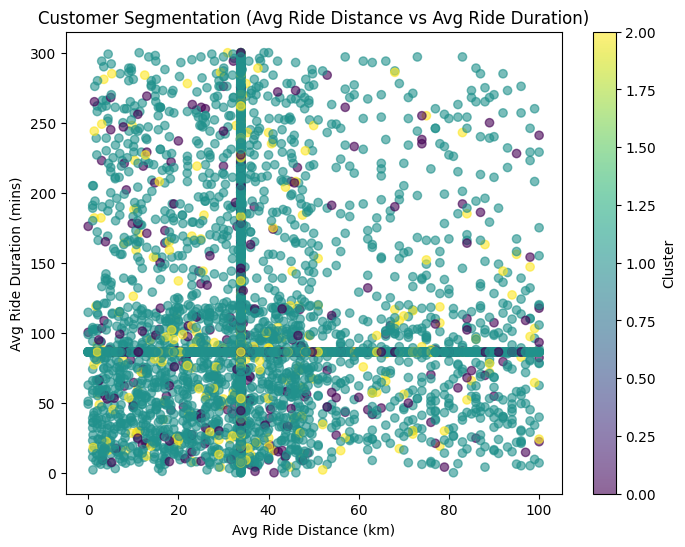

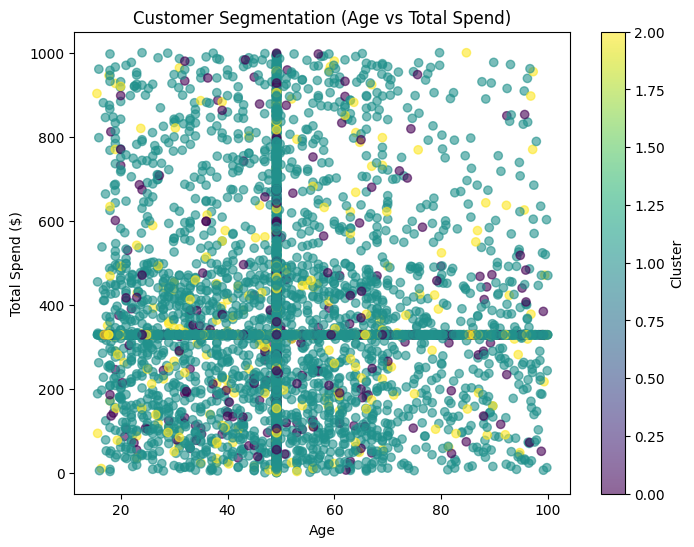

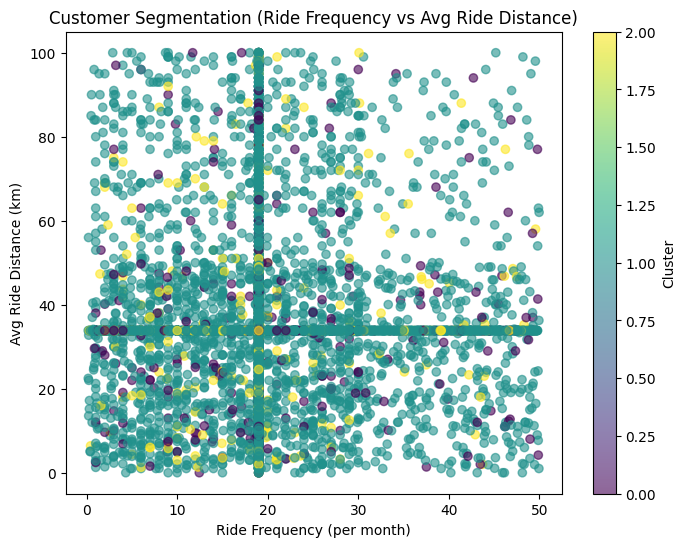

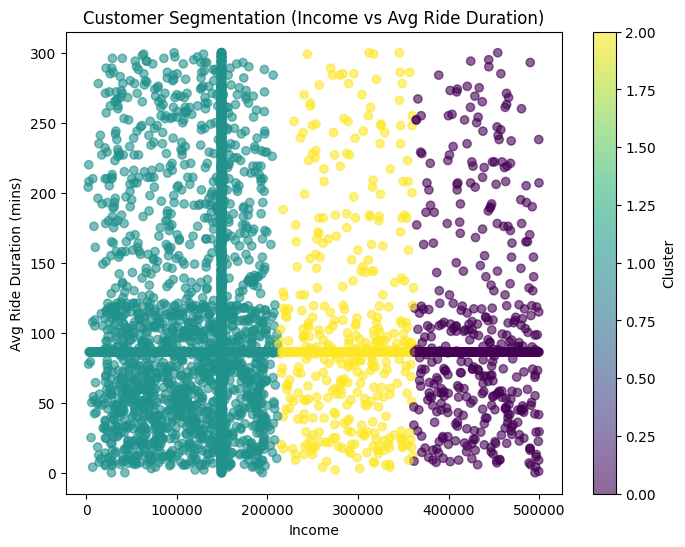

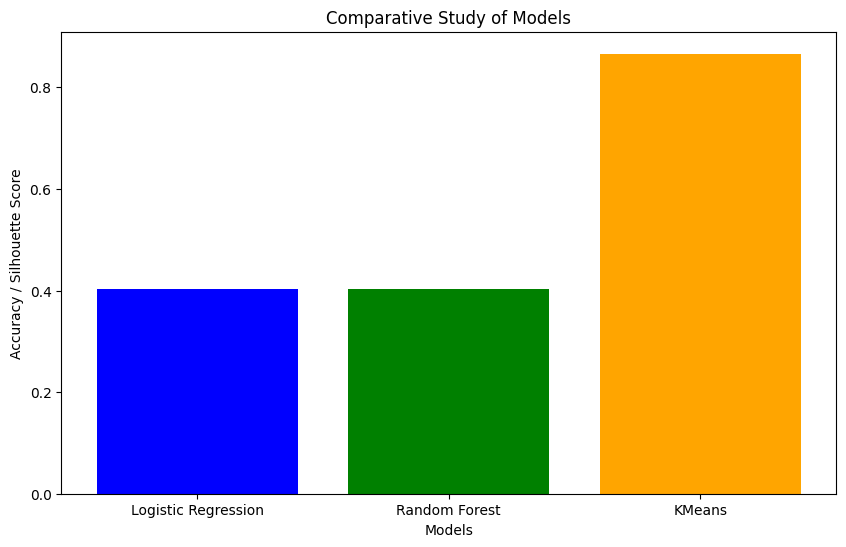

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# 1. Start a Spark session (if not started already)
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

# 2. Load Cleaned Dataset Locally
cleaned_dataset_path = "/content/part-00000-0afb19c5-27a3-4cce-8f99-0cb43406a020-c000.csv"  # Replace with your local path
df_cleaned = spark.read.csv(cleaned_dataset_path, header=True, inferSchema=True)

# Rename the problematic column to simplify access
df_cleaned = df_cleaned.withColumnRenamed("Loyalty_Member (Y/N)", "Loyalty_Member")

# 3. Handle null values and inconsistencies in "Loyalty_Member"
df_cleaned = df_cleaned.withColumn("Loyalty_Member",
                                   when(col("Loyalty_Member").isNull(), "Unknown")
                                   .when(col("Loyalty_Member") == 1, "Y")
                                   .when(col("Loyalty_Member") == 0, "N")
                                   .otherwise(col("Loyalty_Member")))

# 4. Convert the target column "Loyalty_Member" to a numerical label using StringIndexer
indexer = StringIndexer(inputCol="Loyalty_Member", outputCol="label")
df_cleaned = indexer.fit(df_cleaned).transform(df_cleaned)

# 5. Assemble features into a single vector column for classification
assembler = VectorAssembler(inputCols=["Age", "Income", "Ride_Frequency (per month)", "Avg_Ride_Distance (km)",
                                       "Avg_Ride_Duration (mins)", "Total_Spend ($)"], outputCol="features")
df_features = assembler.transform(df_cleaned)

# Train/Test Split for classification models
train, test = df_features.randomSplit([0.7, 0.3], seed=42)

# 6. Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)
lr_model = lr.fit(train)
df_lr_predictions = lr_model.transform(test)

# 7. Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
rf_model = rf.fit(train)
df_rf_predictions = rf_model.transform(test)

# 8. KMeans Clustering
kmeans = KMeans(k=3, featuresCol="features", predictionCol="prediction")
kmeans_model = kmeans.fit(df_features)
df_kmeans_predictions = kmeans_model.transform(df_features)

# 9. Model Evaluation for Logistic Regression and Random Forest
lr_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = lr_evaluator.evaluate(df_lr_predictions)

rf_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rf_accuracy = rf_evaluator.evaluate(df_rf_predictions)

# 10. Calculate Silhouette Score for KMeans
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction")
kmeans_silhouette = evaluator.evaluate(df_kmeans_predictions)
print(f"KMeans Silhouette Score: {kmeans_silhouette:.4f}")

# 11. Print accuracies of Logistic Regression and Random Forest
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# 12. Visualizing Multiple Customer Segmentation Variants

# Variant 1: Segmenting by Age vs Income
df_kmeans_pd = df_kmeans_predictions.select("Age", "Income", "prediction").toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(df_kmeans_pd["Age"], df_kmeans_pd["Income"], c=df_kmeans_pd["prediction"], cmap='viridis', alpha=0.6)
plt.title('Customer Segmentation (Age vs Income)')
plt.xlabel('Age')
plt.ylabel('Income')
plt.colorbar(label='Cluster')
plt.show()

# Variant 2: Segmenting by Ride Frequency vs Total Spend
df_kmeans_pd = df_kmeans_predictions.select("Ride_Frequency (per month)", "Total_Spend ($)", "prediction").toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(df_kmeans_pd["Ride_Frequency (per month)"], df_kmeans_pd["Total_Spend ($)"], c=df_kmeans_pd["prediction"], cmap='viridis', alpha=0.6)
plt.title('Customer Segmentation (Ride Frequency vs Total Spend)')
plt.xlabel('Ride Frequency (per month)')
plt.ylabel('Total Spend ($)')
plt.colorbar(label='Cluster')
plt.show()

# Variant 3: Segmenting by Avg Ride Distance vs Avg Ride Duration
df_kmeans_pd = df_kmeans_predictions.select("Avg_Ride_Distance (km)", "Avg_Ride_Duration (mins)", "prediction").toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(df_kmeans_pd["Avg_Ride_Distance (km)"], df_kmeans_pd["Avg_Ride_Duration (mins)"], c=df_kmeans_pd["prediction"], cmap='viridis', alpha=0.6)
plt.title('Customer Segmentation (Avg Ride Distance vs Avg Ride Duration)')
plt.xlabel('Avg Ride Distance (km)')
plt.ylabel('Avg Ride Duration (mins)')
plt.colorbar(label='Cluster')
plt.show()

# Variant 4: Segmenting by Age vs Total Spend
df_kmeans_pd = df_kmeans_predictions.select("Age", "Total_Spend ($)", "prediction").toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(df_kmeans_pd["Age"], df_kmeans_pd["Total_Spend ($)"], c=df_kmeans_pd["prediction"], cmap='viridis', alpha=0.6)
plt.title('Customer Segmentation (Age vs Total Spend)')
plt.xlabel('Age')
plt.ylabel('Total Spend ($)')
plt.colorbar(label='Cluster')
plt.show()

# Variant 5: Segmenting by Ride Frequency vs Avg Ride Distance
df_kmeans_pd = df_kmeans_predictions.select("Ride_Frequency (per month)", "Avg_Ride_Distance (km)", "prediction").toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(df_kmeans_pd["Ride_Frequency (per month)"], df_kmeans_pd["Avg_Ride_Distance (km)"], c=df_kmeans_pd["prediction"], cmap='viridis', alpha=0.6)
plt.title('Customer Segmentation (Ride Frequency vs Avg Ride Distance)')
plt.xlabel('Ride Frequency (per month)')
plt.ylabel('Avg Ride Distance (km)')
plt.colorbar(label='Cluster')
plt.show()

# Variant 6: Segmenting by Income vs Avg Ride Duration
df_kmeans_pd = df_kmeans_predictions.select("Income", "Avg_Ride_Duration (mins)", "prediction").toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(df_kmeans_pd["Income"], df_kmeans_pd["Avg_Ride_Duration (mins)"], c=df_kmeans_pd["prediction"], cmap='viridis', alpha=0.6)
plt.title('Customer Segmentation (Income vs Avg Ride Duration)')
plt.xlabel('Income')
plt.ylabel('Avg Ride Duration (mins)')
plt.colorbar(label='Cluster')
plt.show()

# 13. Comparative Study Graph
# Collect accuracy results for comparative visualization
models = ['Logistic Regression', 'Random Forest', 'KMeans']
accuracies = [lr_accuracy, rf_accuracy, kmeans_silhouette]

# Plot the comparison of the models
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.title('Comparative Study of Models')
plt.xlabel('Models')
plt.ylabel('Accuracy / Silhouette Score')
plt.show()

# Stop the Spark session
spark.stop()


KMeans Silhouette Score: 0.8838


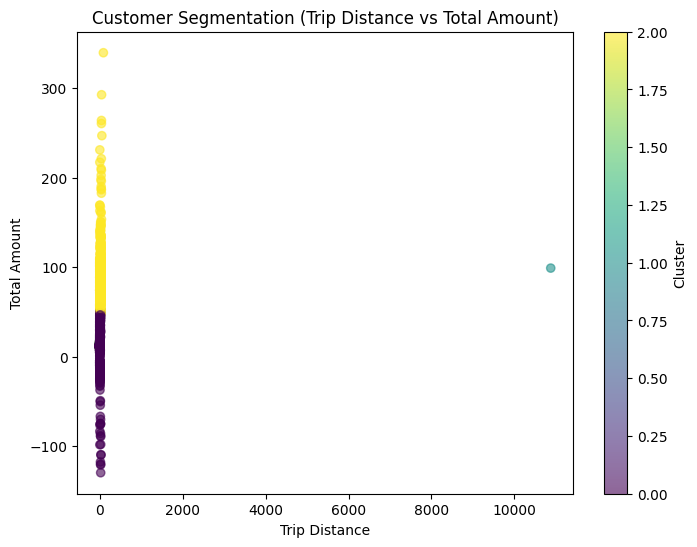

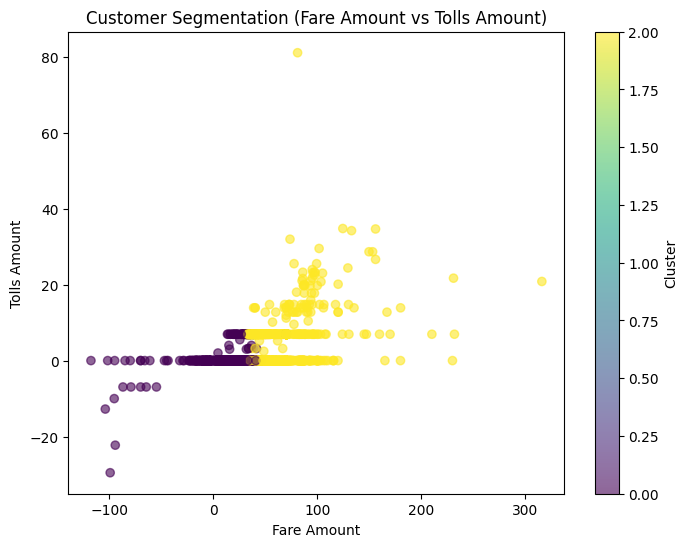

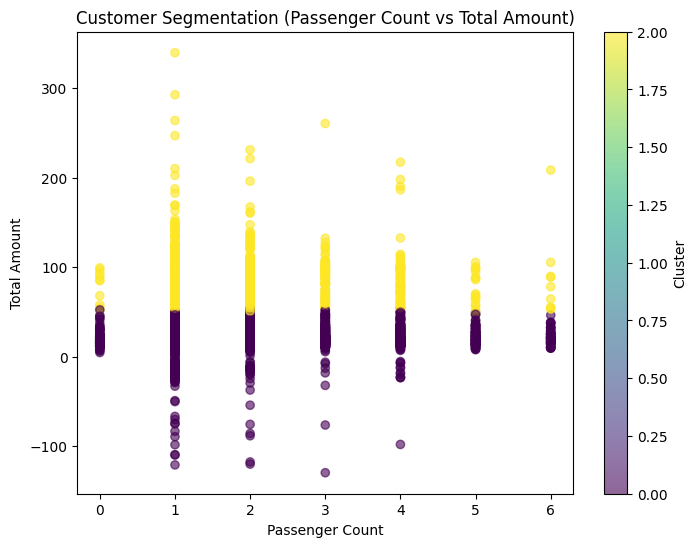

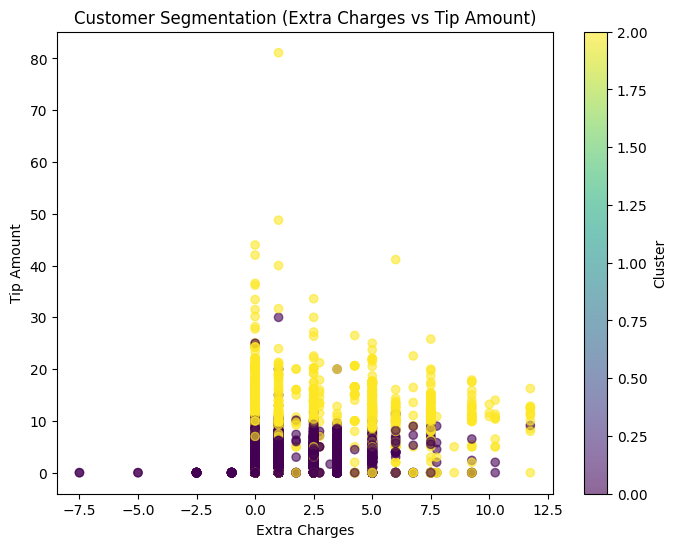

Logistic Regression Accuracy: 0.9997
Random Forest Accuracy: 0.9955
Decision Tree Accuracy: 0.9955


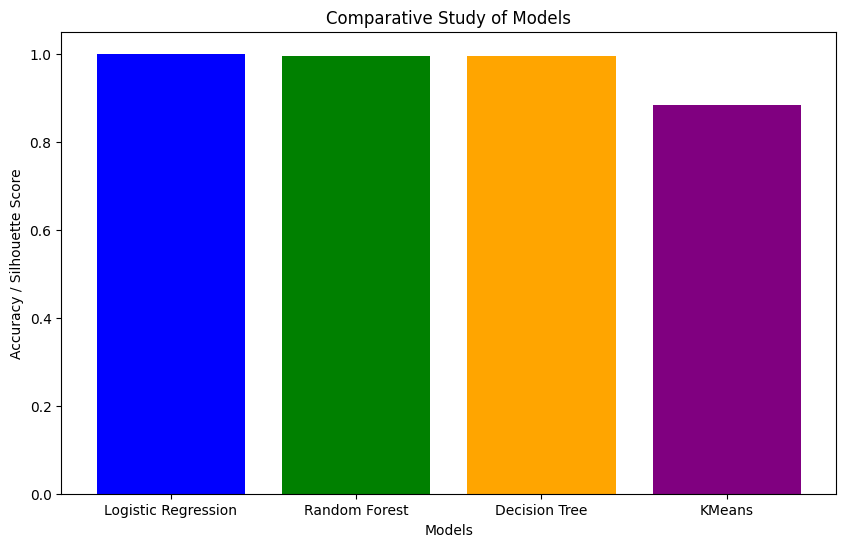

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# 1. Start a Spark session (if not started already)
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

# 2. Load Cleaned Dataset Locally
cleaned_dataset_path = "/content/part-00000-1e20fd0d-eae5-49aa-811e-66dbc8709234-c000.csv"  # Replace with your local path
df_cleaned = spark.read.csv(cleaned_dataset_path, header=True, inferSchema=True)

# 3. Check for nulls and handle any column inconsistencies
df_cleaned = df_cleaned.na.drop()  # Drop rows with any null values (you can handle this differently if needed)

# 4. Assemble features into a single vector column for clustering (using available columns)
feature_cols = ["trip_distance", "fare_amount", "passenger_count", "total_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "congestion_surcharge", "Airport_fee"]

# Check if all required columns exist
missing_cols = [col for col in feature_cols if col not in df_cleaned.columns]
if missing_cols:
    print(f"Missing columns in dataset: {missing_cols}")
else:
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_features = assembler.transform(df_cleaned)

    # 5. KMeans Clustering
    kmeans = KMeans(k=3, featuresCol="features", predictionCol="prediction")
    kmeans_model = kmeans.fit(df_features)
    df_kmeans_predictions = kmeans_model.transform(df_features)

    # 6. Calculate Silhouette Score for KMeans
    evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction")
    kmeans_silhouette = evaluator.evaluate(df_kmeans_predictions)
    print(f"KMeans Silhouette Score: {kmeans_silhouette:.4f}")

    # Visualizing the clustering results: trip_distance vs total_amount
    df_kmeans_pd = df_kmeans_predictions.select("trip_distance", "total_amount", "prediction").toPandas()
    plt.figure(figsize=(8, 6))
    plt.scatter(df_kmeans_pd["trip_distance"], df_kmeans_pd["total_amount"], c=df_kmeans_pd["prediction"], cmap='viridis', alpha=0.6)
    plt.title('Customer Segmentation (Trip Distance vs Total Amount)')
    plt.xlabel('Trip Distance')
    plt.ylabel('Total Amount')
    plt.colorbar(label='Cluster')
    plt.show()

    # Visualizing additional parameters for segmentation
    # Example 1: Fare Amount vs Tolls Amount
    df_kmeans_pd = df_kmeans_predictions.select("fare_amount", "tolls_amount", "prediction").toPandas()
    plt.figure(figsize=(8, 6))
    plt.scatter(df_kmeans_pd["fare_amount"], df_kmeans_pd["tolls_amount"], c=df_kmeans_pd["prediction"], cmap='viridis', alpha=0.6)
    plt.title('Customer Segmentation (Fare Amount vs Tolls Amount)')
    plt.xlabel('Fare Amount')
    plt.ylabel('Tolls Amount')
    plt.colorbar(label='Cluster')
    plt.show()

    # Example 2: Passenger Count vs Total Amount
    df_kmeans_pd = df_kmeans_predictions.select("passenger_count", "total_amount", "prediction").toPandas()
    plt.figure(figsize=(8, 6))
    plt.scatter(df_kmeans_pd["passenger_count"], df_kmeans_pd["total_amount"], c=df_kmeans_pd["prediction"], cmap='viridis', alpha=0.6)
    plt.title('Customer Segmentation (Passenger Count vs Total Amount)')
    plt.xlabel('Passenger Count')
    plt.ylabel('Total Amount')
    plt.colorbar(label='Cluster')
    plt.show()

    # Example 3: Extra Charges vs Tip Amount
    df_kmeans_pd = df_kmeans_predictions.select("extra", "tip_amount", "prediction").toPandas()
    plt.figure(figsize=(8, 6))
    plt.scatter(df_kmeans_pd["extra"], df_kmeans_pd["tip_amount"], c=df_kmeans_pd["prediction"], cmap='viridis', alpha=0.6)
    plt.title('Customer Segmentation (Extra Charges vs Tip Amount)')
    plt.xlabel('Extra Charges')
    plt.ylabel('Tip Amount')
    plt.colorbar(label='Cluster')
    plt.show()

    # 7. Prepare the data for Machine Learning classifiers
    # Let's assume we're predicting whether a customer spends above a threshold, based on 'total_amount'
    df_cleaned = df_cleaned.withColumn("spend_above_threshold", when(col("total_amount") > 50, 1).otherwise(0))  # Arbitrary threshold of 50

    # Assemble the features again for classification models
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_features = assembler.transform(df_cleaned)

    # Train/Test Split for classification models
    train, test = df_features.randomSplit([0.7, 0.3], seed=42)

    # 8. Logistic Regression
    lr = LogisticRegression(featuresCol="features", labelCol="spend_above_threshold")
    lr_model = lr.fit(train)
    df_lr_predictions = lr_model.transform(test)

    # 9. Random Forest
    rf = RandomForestClassifier(featuresCol="features", labelCol="spend_above_threshold", numTrees=100)
    rf_model = rf.fit(train)
    df_rf_predictions = rf_model.transform(test)

    # 10. Decision Tree
    dt = DecisionTreeClassifier(featuresCol="features", labelCol="spend_above_threshold")
    dt_model = dt.fit(train)
    df_dt_predictions = dt_model.transform(test)

    # 11. Model Evaluation for classifiers
    evaluator = MulticlassClassificationEvaluator(labelCol="spend_above_threshold", predictionCol="prediction", metricName="accuracy")

    # Evaluate Logistic Regression
    lr_accuracy = evaluator.evaluate(df_lr_predictions)

    # Evaluate Random Forest
    rf_accuracy = evaluator.evaluate(df_rf_predictions)

    # Evaluate Decision Tree
    dt_accuracy = evaluator.evaluate(df_dt_predictions)

    print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
    print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
    print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")

    # 12. Comparative Study Graph
    models = ['Logistic Regression', 'Random Forest', 'Decision Tree', 'KMeans']
    accuracies = [lr_accuracy, rf_accuracy, dt_accuracy, kmeans_silhouette]

    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'purple'])
    plt.title('Comparative Study of Models')
    plt.xlabel('Models')
    plt.ylabel('Accuracy / Silhouette Score')
    plt.show()

# Stop the Spark session
spark.stop()


In [ ]:
from pyspark.sql import SparkSession

# Restart the Spark session
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

# Verify if the session is active
print(spark.version)  # Should print the Spark version if session is active


3.5.3


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Step 1: Restart or ensure Spark session is running
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

# Check if the Spark session is active
print(spark.version)

# Step 2: Re-load or ensure the datasets (train and test) are available
# Assuming the dataset is a CSV file, replace the path accordingly
train = spark.read.csv("/content/part-00000-1e20fd0d-eae5-49aa-811e-66dbc8709234-c000.csv", header=True, inferSchema=True)
test = spark.read.csv("/content/part-00000-1e20fd0d-eae5-49aa-811e-66dbc8709234-c000.csv", header=True, inferSchema=True)

# Show the first few rows to ensure the data is loaded correctly
train.show(5)
test.show(5)

# Step 3: Feature Engineering
# Assuming the relevant features are numerical columns
assembler = VectorAssembler(
    inputCols=["fare_amount", "tip_amount", "total_amount", "trip_distance", "passenger_count"],  # Replace with your actual feature columns
    outputCol="features"
)

# Transform train and test datasets to include the 'features' column
train = assembler.transform(train)
test = assembler.transform(test)

# Step 4: Ensure the label column 'spend_above_threshold' exists and is properly defined
# Example: Assuming 'spend_above_threshold' is derived as a binary classification problem (e.g., above or below $50)
from pyspark.sql.functions import col
train = train.withColumn("spend_above_threshold", (col("total_amount") > 50).cast("double"))
test = test.withColumn("spend_above_threshold", (col("total_amount") > 50).cast("double"))

# Function to calculate accuracy for both training and testing datasets
def evaluate_model(model, train_data, test_data, label_col="spend_above_threshold", prediction_col="prediction"):
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="accuracy")

    # Evaluate on training data
    train_predictions = model.transform(train_data)
    train_accuracy = evaluator.evaluate(train_predictions)

    # Evaluate on test data
    test_predictions = model.transform(test_data)
    test_accuracy = evaluator.evaluate(test_predictions)

    return train_accuracy, test_accuracy

# Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="spend_above_threshold")
lr_model = lr.fit(train)  # Fit the model to training data
lr_train_accuracy, lr_test_accuracy = evaluate_model(lr_model, train, test)

# Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="spend_above_threshold", numTrees=100)
rf_model = rf.fit(train)
rf_train_accuracy, rf_test_accuracy = evaluate_model(rf_model, train, test)

# Decision Tree
dt = DecisionTreeClassifier(featuresCol="features", labelCol="spend_above_threshold")
dt_model = dt.fit(train)
dt_train_accuracy, dt_test_accuracy = evaluate_model(dt_model, train, test)

# Step 5: Print results
print(f"Logistic Regression: Train Accuracy = {lr_train_accuracy:.4f}, Test Accuracy = {lr_test_accuracy:.4f}")
print(f"Random Forest: Train Accuracy = {rf_train_accuracy:.4f}, Test Accuracy = {rf_test_accuracy:.4f}")
print(f"Decision Tree: Train Accuracy = {dt_train_accuracy:.4f}, Test Accuracy = {dt_test_accuracy:.4f}")

# Step 6: Check for overfitting
def check_overfitting(train_accuracy, test_accuracy):
    if train_accuracy > test_accuracy:
        print("Model may be overfitting!")
    elif train_accuracy == test_accuracy:
        print("Model is performing consistently on training and testing data.")
    else:
        print("Model is underfitting!")

# Check for overfitting in all models
print("\nChecking for Overfitting:\n")
check_overfitting(lr_train_accuracy, lr_test_accuracy)
check_overfitting(rf_train_accuracy, rf_test_accuracy)
check_overfitting(dt_train_accuracy, dt_test_accuracy)


3.5.3
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2024-01-01 00:41:06|  2024-01-01 00:53:42|              1|          1.5|         1|                 N|         164|          79|           1|       12.8|  3.5|    0.5|   

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Step 1: Restart or ensure Spark session is running
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

# Check if the Spark session is active
print(spark.version)

# Step 2: Re-load or ensure the datasets (train and test) are available
# Assuming the dataset is a CSV file, replace the path accordingly
train = spark.read.csv("/content/part-00000-1e20fd0d-eae5-49aa-811e-66dbc8709234-c000.csv", header=True, inferSchema=True)
test = spark.read.csv("/content/synthetic_taxi_data.csv", header=True, inferSchema=True)

# Show the first few rows to ensure the data is loaded correctly
train.show(5)
test.show(5)

# Step 3: Feature Engineering
# Assuming the relevant features are numerical columns
assembler = VectorAssembler(
    inputCols=["fare_amount", "tip_amount", "total_amount", "trip_distance", "passenger_count"],  # Replace with your actual feature columns
    outputCol="features"
)

# Transform train and test datasets to include the 'features' column
train = assembler.transform(train)
test = assembler.transform(test)

# Step 4: Ensure the label column 'spend_above_threshold' exists and is properly defined
# Example: Assuming 'spend_above_threshold' is derived as a binary classification problem (e.g., above or below $50)
from pyspark.sql.functions import col
train = train.withColumn("spend_above_threshold", (col("total_amount") > 50).cast("double"))
test = test.withColumn("spend_above_threshold", (col("total_amount") > 50).cast("double"))

# Function to calculate accuracy for both training and testing datasets
def evaluate_model(model, train_data, test_data, label_col="spend_above_threshold", prediction_col="prediction"):
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="accuracy")

    # Evaluate on training data
    train_predictions = model.transform(train_data)
    train_accuracy = evaluator.evaluate(train_predictions)

    # Evaluate on test data
    test_predictions = model.transform(test_data)
    test_accuracy = evaluator.evaluate(test_predictions)

    return train_accuracy, test_accuracy

# Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="spend_above_threshold")
lr_model = lr.fit(train)  # Fit the model to training data
lr_train_accuracy, lr_test_accuracy = evaluate_model(lr_model, train, test)

# Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="spend_above_threshold", numTrees=100)
rf_model = rf.fit(train)
rf_train_accuracy, rf_test_accuracy = evaluate_model(rf_model, train, test)

# Decision Tree
dt = DecisionTreeClassifier(featuresCol="features", labelCol="spend_above_threshold")
dt_model = dt.fit(train)
dt_train_accuracy, dt_test_accuracy = evaluate_model(dt_model, train, test)

# Step 5: Print results
print(f"Logistic Regression: Train Accuracy = {lr_train_accuracy:.4f}, Test Accuracy = {lr_test_accuracy:.4f}")
print(f"Random Forest: Train Accuracy = {rf_train_accuracy:.4f}, Test Accuracy = {rf_test_accuracy:.4f}")
print(f"Decision Tree: Train Accuracy = {dt_train_accuracy:.4f}, Test Accuracy = {dt_test_accuracy:.4f}")

# Step 6: Check for overfitting
def check_overfitting(train_accuracy, test_accuracy):
    if train_accuracy > test_accuracy:
        print("Model may be overfitting!")
    elif train_accuracy == test_accuracy:
        print("Model is performing consistently on training and testing data.")
    else:
        print("Model is underfitting!")

# Check for overfitting in all models
print("\nChecking for Overfitting:\n")
check_overfitting(lr_train_accuracy, lr_test_accuracy)
check_overfitting(rf_train_accuracy, rf_test_accuracy)
check_overfitting(dt_train_accuracy, dt_test_accuracy)


3.5.3
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2024-01-01 00:41:06|  2024-01-01 00:53:42|              1|          1.5|         1|                 N|         164|          79|           1|       12.8|  3.5|    0.5|   